In [120]:
import tensorflow_hub as hub
import tensorflow as tf

import matplotlib.pyplot as plt
import urllib.request as ur
import pandas as pd
import numpy as np
import itertools
import skimage
import pickle
import glob
import json
import ast
import cv2
import re

from skimage import data, io
from skimage.segmentation import flood, flood_fill
from collections import Counter
from sklearn.manifold import TSNE
from pandas.io.json import json_normalize
from matplotlib import cm
from utils import read_config
from pathlib import Path
from copy import deepcopy
from tqdm import tqdm
from yolov4.tf import YOLOv4

from skimage import exposure
from skimage import transform
from skimage import color
from tensorflow.keras.models import load_model
import face_recognition
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.preprocessing import LabelEncoder
from concurrent.futures import TimeoutError
from pebble import ProcessPool, ProcessExpired
import seaborn as sns
from collections import Counter
import cv2 as cv
import pytesseract
from imutils.object_detection import non_max_suppression
from textblob import TextBlob
from wordcloud import WordCloud
from skimage import feature as skfeature
from scipy.stats import iqr
import plotly.express as px

cache_dir = Path('data/cache/chkp2')
cache_dir.mkdir(exist_ok=True, parents=True)

def load_pickle(path):
    print("Loading from:", path)
    with open(path, 'rb') as fh:
        return pickle.load(fh)

def save_pickle(obj, path):
    print("Saving to:", path)
    with open(path, 'wb') as fh:
        return pickle.dump(obj, fh)

In [2]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  0


In [3]:
config = read_config("config.json")
config['dataset_path'] = Path(config['dataset_path'])

In [4]:
videos_df = pd.read_pickle(config['dataset_path'] / 'chkp1.pkl')
print(videos_df.shape)
videos_df.head(3)

(8606, 84)


video_id trending_date  \
10  9wRQljFNDW8    2017-11-14   
36  Om_zGhJLZ5U    2017-11-14   
41  goP4Z5wyOlM    2017-11-14   

                                                title   channel_title  \
10  Dion Lewis' 103-Yd Kick Return TD vs. Denver! ...             NFL   
36     TL;DW - Every DCEU Movie Before Justice League  Screen Junkies   
41  Iraq-Iran earthquake: Deadly tremor hits borde...        BBC News   

                publish_time  \
10 2017-11-13 02:05:26+00:00   
36 2017-11-12 18:00:03+00:00   
41 2017-11-12 21:16:40+00:00   

                                                 tags   views  likes  \
10  NFL|"Football"|"offense"|"defense"|"afc"|"nfc"...   81377    655   
36  screenjunkies|"screen junkies"|"sj news"|"hone...  288922   7515   
41  bbc|"bbc news"|"news"|"iran"|"iran news"|"iraq...   34785    308   

    dislikes  comment_count  ... description_word_count  \
10        25            177  ...                  177.0   
36       792           2111  ...                   61.0   
41        26            413  ...                   90.0   

    channel_title_word_count  description_url_count  description_url_ratio  \
10                         1                   16.0               0.090395   
36                         2                    4.0               0.065574   
41                         2                    6.0               0.066667   

   shouting_ratio_title shouting_ratio_description  \
10             0.275862                   0.096573   
36             0.351351                   0.070740   
41             0.132075                   0.160542   

    shouting_ratio_channel_title  \
10                      1.000000   
36                      0.153846   
41                      0.571429   

                                description_embedding  \
10  [0.1286950558423996, 0.09136795997619629, -0.0...   
36  [0.08945216238498688, 0.012981911189854145, 0....   
41  [-0.026162145659327507, 0.023051297292113304, ...   

                                      title_embedding  channel_title_hash  
10  [-0.011210336349904537, -0.02326270006597042, ...       -3.408266e+10  
36  [0.046388525515794754, 0.05515308678150177, -0...       -7.891112e+10  
41  [0.010515631176531315, 0.1938595026731491, -0....       -2.124116e+10  

[3 rows x 84 columns]

In [5]:
videos_df.columns

Index(['video_id', 'trending_date', 'title', 'channel_title', 'publish_time',
       'tags', 'views', 'likes', 'dislikes', 'comment_count', 'thumbnail_link',
       'comments_disabled', 'ratings_disabled', 'video_error_or_removed',
       'description', 'origin', 'category_id', 'category_text',
       'publish_time_day', 'publish_time_month', 'publish_time_year',
       'publish_time_weekday', 'publish_time_quarter', 'publish_time_hour',
       'publish_time_minute', 'publish_time_second', 'trending_date_day',
       'trending_date_month', 'trending_date_year', 'trending_date_weekday',
       'trending_date_quarter', 'trending_date_end', 'trending_date_start',
       'trending_span', 'trending_span_days', 'publish_to_trending_span',
       'publish_to_trending_span_in_hours', 'likes_first', 'likes_last',
       'likes_diff', 'dislikes_first', 'dislikes_last', 'dislikes_diff',
       'views_first', 'views_last', 'views_diff', 'comment_count_first',
       'comment_count_last', 'comment_

In [6]:
videos_df = deepcopy(videos_df[['video_id', 'thumbnail_link', 'category_text']])
videos_df.drop_duplicates(inplace=True)
videos_df.set_index('video_id', inplace=True)
print(videos_df.shape)
videos_df.head(3)

(8606, 2)


thumbnail_link category_text
video_id                                                                 
9wRQljFNDW8  https://i.ytimg.com/vi/9wRQljFNDW8/default.jpg           NaN
Om_zGhJLZ5U  https://i.ytimg.com/vi/Om_zGhJLZ5U/default.jpg           NaN
goP4Z5wyOlM  https://i.ytimg.com/vi/goP4Z5wyOlM/default.jpg           NaN

### Download images

Wyjątki - Są to filmy, które nie są dostępne (np. są prywatne), przykładem kanału z takim filmem jest The View, który postuje filmy z różnych programów telewizyjnych. Takie filmy mogą być obiektem roszczeń o prawa autorskie, pomimo tego, że były trending i ich thumbnaile będą niedostępne.

In [7]:
# count_unknown = 0
# for index, row in videos_df.iterrows():
#     path = config['dataset_path'] / 'images/{}.jpg'.format(row['video_id'])
#     link = re.sub(r'(default)', r'hq\1', row['thumbnail_link'])
#     try:
#         ur.urlretrieve(link, path)
#     except:
#         
#         count_unknown += 1
# count_unknown

### Thumbnail embedding

In [8]:
def mod_img(df, func, colname='', *args):
    if isinstance(colname, list):
        fname = '_'.join(colname)+'.pkl'
    else:
        fname = colname+'.pkl'

    if (cache_dir / fname).exists():
        col_val_list = load_pickle(cache_dir / fname)
    else:
        col_val_list = []
        for index, row in tqdm(df.iterrows(), total=df.shape[0]):
            try:
                col_val_list.append(func(index, *args))
            except:
                col_val_list.append(tuple(np.NaN for _ in colname) if isinstance(colname, list) else np.NaN)
        save_pickle(col_val_list, cache_dir / fname)

    print(df.shape, len(col_val_list))
    df[colname] = col_val_list
    return df

![https://ai.googleblog.com/2019/05/efficientnet-improving-accuracy-and.html](https://1.bp.blogspot.com/-oNSfIOzO8ko/XO3BtHnUx0I/AAAAAAAAEKk/rJ2tHovGkzsyZnCbwVad-Q3ZBnwQmCFsgCEwYBhgL/s640/image3.png)

In [9]:
# feature_ex_model = hub.load("https://tfhub.dev/tensorflow/efficientnet/b7/feature-vector/1")

In [10]:
def fv_func(index, *args):
    max_dim = 512
    # Read img
    img = tf.io.read_file('data/images/{}.jpg'.format(index))
    img = tf.image.decode_image(img, channels=3)
    # Preprocess img (scale to max_dim)
    img = tf.image.convert_image_dtype(img, tf.float32)
    shape = tf.cast(tf.shape(img)[:-1], tf.float32)
    new_shape = tf.cast(shape * (max_dim / max(shape)), tf.int32) # shape * scale
    img = tf.image.resize(img, new_shape)
    img = img[tf.newaxis, :]
    return np.squeeze(feature_ex_model(img).numpy())

# Reduce df size for testing purposes (and remove rows with nans)
# videos_df = videos_df.dropna()
# videos_df = videos_df.head(50)

# videos_df = mod_img(videos_df, fv_func, colname='feature_vector')
videos_df = pd.read_pickle('data/fv_videos_df.pkl')
print(videos_df.shape)
videos_df.head(3)

(8606, 3)


thumbnail_link category_text  \
video_id                                                                    
9wRQljFNDW8  https://i.ytimg.com/vi/9wRQljFNDW8/default.jpg           NaN   
Om_zGhJLZ5U  https://i.ytimg.com/vi/Om_zGhJLZ5U/default.jpg           NaN   
goP4Z5wyOlM  https://i.ytimg.com/vi/goP4Z5wyOlM/default.jpg           NaN   

                                                feature_vector  
video_id                                                        
9wRQljFNDW8  [0.06580926, -0.12843476, -0.04167219, -0.0986...  
Om_zGhJLZ5U  [0.00328945, -0.09353591, 0.4361128, -0.185314...  
goP4Z5wyOlM  [0.33117568, 0.068013296, 0.3588107, -0.179159...

In [11]:
tensor = videos_df['feature_vector'].values

In [12]:
tensor

array([array([ 0.06580926, -0.12843476, -0.04167219, ..., -0.10349274,
       -0.14756769, -0.01891625], dtype=float32),
       array([ 0.00328945, -0.09353591,  0.4361128 , ...,  0.2592871 ,
       -0.13721035, -0.04288537], dtype=float32),
       array([0.33117568, 0.0680133 , 0.3588107 , ..., 0.06841249, 0.03805888,
       0.00631504], dtype=float32),
       ...,
       array([ 0.11037743, -0.10578129,  0.37940934, ...,  0.15567924,
       -0.12508784, -0.12738986], dtype=float32),
       array([ 0.03912545, -0.14649555,  0.48778644, ...,  0.02884086,
       -0.19759433, -0.12109306], dtype=float32),
       array([ 0.3024939 , -0.11728705,  0.58624357, ...,  0.20107388,
       -0.14625709, -0.1130297 ], dtype=float32)], dtype=object)

### t-SNE projection

In [13]:
videos_nocat_df = videos_df.dropna()
tsne_fv = videos_nocat_df['feature_vector'].values
tsne_fv = np.stack(tsne_fv, axis=0)
tsne_fv.shape

(2598, 2560)

In [14]:
tsne_cat = videos_nocat_df['category_text'].values
tsne_cat

array(['Comedy', 'Music', 'Gaming', ..., 'Music', 'Music',
       'Entertainment'], dtype=object)

In [15]:
unique_cat = list(set(videos_nocat_df.category_text.values))
unique_cat

['News & Politics',
 'People & Blogs',
 'Comedy',
 'Nonprofits & Activism',
 'Education',
 'Music',
 'Howto & Style',
 'Sports',
 'Science & Technology',
 'Entertainment',
 'Autos & Vehicles',
 'Pets & Animals',
 'Shows',
 'Gaming',
 'Film & Animation',
 'Travel & Events']

In [16]:
tsne = TSNE(n_components=2, verbose=1).fit_transform(tsne_fv)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 2598 samples in 0.005s...
[t-SNE] Computed neighbors for 2598 samples in 0.943s...
[t-SNE] Computed conditional probabilities for sample 1000 / 2598
[t-SNE] Computed conditional probabilities for sample 2000 / 2598
[t-SNE] Computed conditional probabilities for sample 2598 / 2598
[t-SNE] Mean sigma: 2.492716
[t-SNE] KL divergence after 250 iterations with early exaggeration: 81.816803
[t-SNE] KL divergence after 1000 iterations: 2.210799


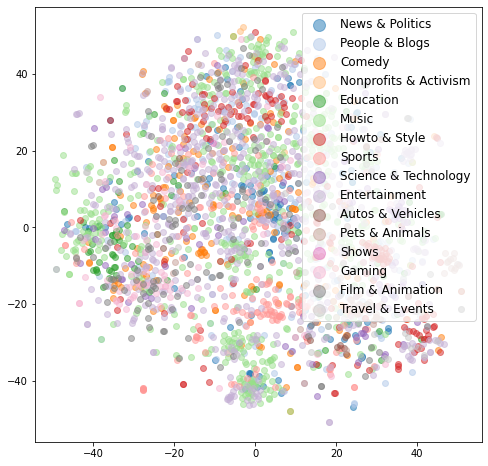

In [17]:
cmap = cm.get_cmap('tab20')
fig, ax = plt.subplots(figsize=(8,8))

for i, cat in enumerate(unique_cat):
    idx = tsne_cat == cat
    ax.scatter(
        tsne[idx, 0],
        tsne[idx, 1],
        c = np.array(cmap(i)).reshape(1,4),
        label = cat,
        alpha = 0.5)
ax.legend(fontsize='large', markerscale=2)
plt.show()

### Object detection with YOLO

In [18]:
# Initialize YOLO v4
yolo = YOLOv4()

yolo.config.parse_names("data/yolo_data/coco.names")
yolo.config.parse_cfg("data/yolo_data/yolov4-tiny.cfg")
yolo.make_model()
yolo.load_weights("data/yolo_data/yolov4-tiny.weights", weights_type="yolo")
# yolo.summary(summary_type="yolo")

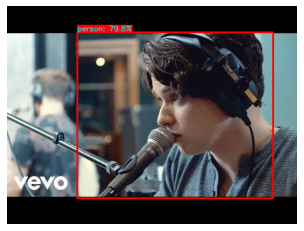

In [19]:
# Example
frame = cv2.imread("data/images/__-22AJoFxY.jpg")
frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
plt.axis('off')
plt.imshow(yolo.draw_bboxes(frame_rgb, yolo.predict(frame_rgb, prob_thresh=0.25)))

In [20]:
def apply_yolo(index, prob_thresh=0.25):
    frame = cv2.imread("data/images/{}.jpg".format(index))
    frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    pred = yolo.predict(frame_rgb, prob_thresh=prob_thresh)
    objects = []
    max_prob_object = (np.nan, -1)
    for i in pred:
        cx, cy, hw, hh, label_id, prob = i
        if prob > prob_thresh:
            object_ = yolo.config.names[label_id]
            objects.append(object_)
            if prob > max_prob_object[1]: max_prob_object = (object_, prob)
    c = Counter(objects)
    try:
        most_common = c.most_common(1)[0][0]
    except IndexError:
        most_common = np.nan
    return c['person'], objects, max_prob_object, most_common

videos_df = mod_img(videos_df, apply_yolo, colname=['people_amount', 'objects', 'max_prob_object', 'most_occurence_object'])
videos_df.head(5)

Loading from: data/cache/chkp2/people_amount_objects_max_prob_object_most_occurence_object.pkl
(8606, 3) 8606
/home/hylomorph/Study/ped/yt_trending_videos/venv/lib/python3.8/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


thumbnail_link category_text  \
video_id                                                                    
9wRQljFNDW8  https://i.ytimg.com/vi/9wRQljFNDW8/default.jpg           NaN   
Om_zGhJLZ5U  https://i.ytimg.com/vi/Om_zGhJLZ5U/default.jpg           NaN   
goP4Z5wyOlM  https://i.ytimg.com/vi/goP4Z5wyOlM/default.jpg           NaN   
8NHA23f7LvU  https://i.ytimg.com/vi/8NHA23f7LvU/default.jpg           NaN   
IE-xepGLVt8  https://i.ytimg.com/vi/IE-xepGLVt8/default.jpg           NaN   

                                                feature_vector  people_amount  \
video_id                                                                        
9wRQljFNDW8  [0.06580926, -0.12843476, -0.04167219, -0.0986...            8.0   
Om_zGhJLZ5U  [0.00328945, -0.09353591, 0.4361128, -0.185314...            3.0   
goP4Z5wyOlM  [0.33117568, 0.068013296, 0.3588107, -0.179159...            0.0   
8NHA23f7LvU  [0.07857016, 0.13853706, -0.124906056, -0.1983...            2.0   
IE-xepGLVt8  [-0.183625, -0.13925688, 0.045083124, -0.11571...            3.0   

                                                       objects  \
video_id                                                         
9wRQljFNDW8  [person, person, person, person, person, perso...   
Om_zGhJLZ5U                           [person, person, person]   
goP4Z5wyOlM                                                 []   
8NHA23f7LvU                                   [person, person]   
IE-xepGLVt8                    [chair, person, person, person]   

                  max_prob_object most_occurence_object  
video_id                                                 
9wRQljFNDW8   (person, 0.5387666)                person  
Om_zGhJLZ5U  (person, 0.87004745)                person  
goP4Z5wyOlM             (nan, -1)                   NaN  
8NHA23f7LvU  (person, 0.86171067)                person  
IE-xepGLVt8  (person, 0.61477196)                person

### Entropia i charakterystyka Eulera obrazu (TODO)

* Euler Number - For 2D objects, the Euler number is the number of objects minus the number of holes.
* The Shannon entropy is defined as S = -sum(pk * log(pk)), where pk are frequency/probability of pixels of value k.

In [21]:
def apply_measures(index):
    img = io.imread('data/images/{}.jpg'.format(index), as_gray=True)
    entropy = skimage.measure.shannon_entropy(img, base=2)
    euler = skimage.measure.euler_number(img)
    return (entropy, euler)

videos_df = mod_img(videos_df, apply_measures, colname=['shannon_entropy', 'euler_number'])
videos_df.head(5)

Loading from: data/cache/chkp2/shannon_entropy_euler_number.pkl
(8606, 7) 8606


thumbnail_link category_text  \
video_id                                                                    
9wRQljFNDW8  https://i.ytimg.com/vi/9wRQljFNDW8/default.jpg           NaN   
Om_zGhJLZ5U  https://i.ytimg.com/vi/Om_zGhJLZ5U/default.jpg           NaN   
goP4Z5wyOlM  https://i.ytimg.com/vi/goP4Z5wyOlM/default.jpg           NaN   
8NHA23f7LvU  https://i.ytimg.com/vi/8NHA23f7LvU/default.jpg           NaN   
IE-xepGLVt8  https://i.ytimg.com/vi/IE-xepGLVt8/default.jpg           NaN   

                                                feature_vector  people_amount  \
video_id                                                                        
9wRQljFNDW8  [0.06580926, -0.12843476, -0.04167219, -0.0986...            8.0   
Om_zGhJLZ5U  [0.00328945, -0.09353591, 0.4361128, -0.185314...            3.0   
goP4Z5wyOlM  [0.33117568, 0.068013296, 0.3588107, -0.179159...            0.0   
8NHA23f7LvU  [0.07857016, 0.13853706, -0.124906056, -0.1983...            2.0   
IE-xepGLVt8  [-0.183625, -0.13925688, 0.045083124, -0.11571...            3.0   

                                                       objects  \
video_id                                                         
9wRQljFNDW8  [person, person, person, person, person, perso...   
Om_zGhJLZ5U                           [person, person, person]   
goP4Z5wyOlM                                                 []   
8NHA23f7LvU                                   [person, person]   
IE-xepGLVt8                    [chair, person, person, person]   

                  max_prob_object most_occurence_object  shannon_entropy  \
video_id                                                                   
9wRQljFNDW8   (person, 0.5387666)                person        12.542644   
Om_zGhJLZ5U  (person, 0.87004745)                person        11.607859   
goP4Z5wyOlM             (nan, -1)                   NaN         6.982875   
8NHA23f7LvU  (person, 0.86171067)                person        11.173872   
IE-xepGLVt8  (person, 0.61477196)                person        11.357105   

             euler_number  
video_id                   
9wRQljFNDW8        -143.0  
Om_zGhJLZ5U        -228.0  
goP4Z5wyOlM         -33.0  
8NHA23f7LvU         -25.0  
IE-xepGLVt8         -13.0

### Segmentacja wododziałowa

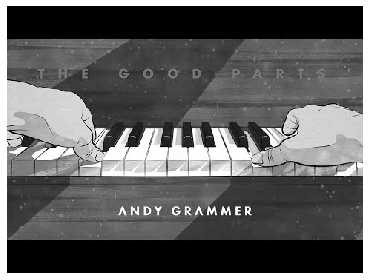

In [22]:
img = io.imread('data/images/1Wk8ZRgXQnY.jpg', as_gray=True)
img = skimage.img_as_int(img)
plt.axis('off')
io.imshow(img)
plt.show()

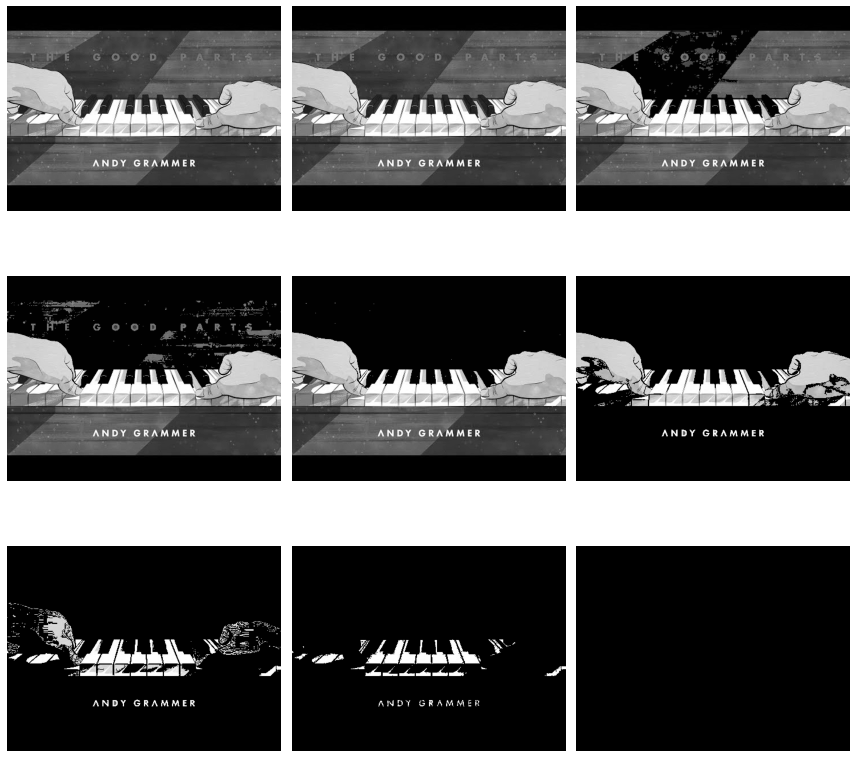

In [23]:
multiplier = 4500

res = []
for i in range(8): 
    tolerance = multiplier * i
    start_point = (int(img.shape[0]/2), int(img.shape[1]/2))
    # start_point = (0, 0)
    res.append(flood_fill(img, start_point, 255, tolerance=tolerance))


fig, ax = plt.subplots(nrows=3, ncols=3, figsize=(12, 12))
ax[0, 0].imshow(img, cmap=plt.cm.gray)
ax[0, 0].axis('off')
for i in range(8):
    m, n = np.unravel_index(i + 1, (3, 3))
    ax[m, n].imshow(res[i], cmap=plt.cm.gray)
    ax[m, n].axis('off')

fig.tight_layout()
plt.show()

In [24]:
def apply_flood(index, iterations=8, multiplier=4500):
    img = io.imread('data/images/{}.jpg'.format(index), as_gray=True)
    img = skimage.img_as_int(img)
    results = []
    for i in range(iterations):
        tolerance = multiplier * i
        start_point = (int(img.shape[0]/2), int(img.shape[1]/2)) # start from the middle
        img_temp = flood_fill(img, start_point, 255, tolerance=tolerance)
        unique, counts = np.unique(img_temp, return_counts=True)
        results.append(dict(zip(unique, counts))[255])
    return results

videos_df = mod_img(videos_df, apply_flood, colname=[f'flood_{i}' for i in range(8)])
videos_df.head(5)

Loading from: data/cache/chkp2/flood_0_flood_1_flood_2_flood_3_flood_4_flood_5_flood_6_flood_7.pkl
(8606, 9) 8606


thumbnail_link category_text  \
video_id                                                                    
9wRQljFNDW8  https://i.ytimg.com/vi/9wRQljFNDW8/default.jpg           NaN   
Om_zGhJLZ5U  https://i.ytimg.com/vi/Om_zGhJLZ5U/default.jpg           NaN   
goP4Z5wyOlM  https://i.ytimg.com/vi/goP4Z5wyOlM/default.jpg           NaN   
8NHA23f7LvU  https://i.ytimg.com/vi/8NHA23f7LvU/default.jpg           NaN   
IE-xepGLVt8  https://i.ytimg.com/vi/IE-xepGLVt8/default.jpg           NaN   

                                                feature_vector  people_amount  \
video_id                                                                        
9wRQljFNDW8  [0.06580926, -0.12843476, -0.04167219, -0.0986...            8.0   
Om_zGhJLZ5U  [0.00328945, -0.09353591, 0.4361128, -0.185314...            3.0   
goP4Z5wyOlM  [0.33117568, 0.068013296, 0.3588107, -0.179159...            0.0   
8NHA23f7LvU  [0.07857016, 0.13853706, -0.124906056, -0.1983...            2.0   
IE-xepGLVt8  [-0.183625, -0.13925688, 0.045083124, -0.11571...            3.0   

                                                       objects  \
video_id                                                         
9wRQljFNDW8  [person, person, person, person, person, perso...   
Om_zGhJLZ5U                           [person, person, person]   
goP4Z5wyOlM                                                 []   
8NHA23f7LvU                                   [person, person]   
IE-xepGLVt8                    [chair, person, person, person]   

                  max_prob_object most_occurence_object  shannon_entropy  \
video_id                                                                   
9wRQljFNDW8   (person, 0.5387666)                person        12.542644   
Om_zGhJLZ5U  (person, 0.87004745)                person        11.607859   
goP4Z5wyOlM             (nan, -1)                   NaN         6.982875   
8NHA23f7LvU  (person, 0.86171067)                person        11.173872   
IE-xepGLVt8  (person, 0.61477196)                person        11.357105   

             euler_number  flood_0   flood_1   flood_2   flood_3   flood_4  \
video_id                                                                     
9wRQljFNDW8        -143.0     48.0    8008.0  134508.0  150069.0  157884.0   
Om_zGhJLZ5U        -228.0     46.0    3130.0   27840.0   47628.0   88412.0   
goP4Z5wyOlM         -33.0   8276.0  108845.0  119302.0  122061.0  122779.0   
8NHA23f7LvU         -25.0    965.0    5798.0  102437.0  171230.0  172020.0   
IE-xepGLVt8         -13.0    103.0   13459.0   37385.0   62385.0  107008.0   

              flood_5   flood_6   flood_7  
video_id                                   
9wRQljFNDW8  161032.0  165137.0  172800.0  
Om_zGhJLZ5U  172800.0  172800.0  172800.0  
goP4Z5wyOlM  123187.0  129621.0  172800.0  
8NHA23f7LvU  172800.0  172800.0  172800.0  
IE-xepGLVt8  123774.0  172800.0  172800.0

### Wczytywanie obrazków

In [25]:
image_paths = sorted(Path('data/images').glob('*.jpg'), key=lambda p: p.name)

video_ids = [p.stem for p in image_paths]
print(video_ids[:5], image_paths[:5])

images = [face_recognition.load_image_file(str(p)) for p in image_paths]

images_df = videos_df[['category_text']]
images_df = images_df.join(pd.Series(images, index=video_ids, name='images'), how='right').sort_index()
images_df

['--uXQQ0h-yQ', '-0CMnp02rNY', '-0NYY8cqdiQ', '-1Hm41N0dUs', '-1yT-K3c6YI'] [PosixPath('data/images/--uXQQ0h-yQ.jpg'), PosixPath('data/images/-0CMnp02rNY.jpg'), PosixPath('data/images/-0NYY8cqdiQ.jpg'), PosixPath('data/images/-1Hm41N0dUs.jpg'), PosixPath('data/images/-1yT-K3c6YI.jpg')]


category_text                                             images
--uXQQ0h-yQ   Entertainment  [[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...
-0CMnp02rNY             NaN  [[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...
-0NYY8cqdiQ             NaN  [[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...
-1Hm41N0dUs             NaN  [[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...
-1yT-K3c6YI  People & Blogs  [[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...
...                     ...                                                ...
zwrlJwed2mQ             NaN  [[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...
zxGg8QqWrRQ             NaN  [[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...
zxUwbflE1SY             NaN  [[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...
zxjv0lo8bU8          Sports  [[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...
zxwfDlhJIpw  People & Blogs  [[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...

[7802 rows x 2 columns]

### Przykładowe obrazki

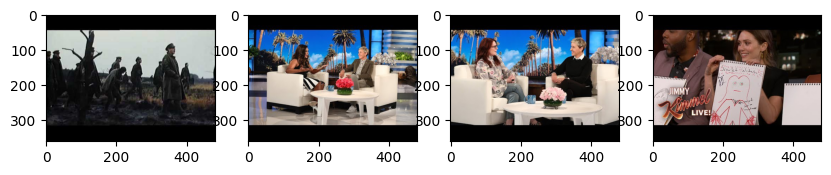

In [26]:
fig, ax = plt.subplots(1,4, figsize=(10,12), dpi=100)

for i in range(4):
    ax[i].imshow(images[i])

plt.show()

## Histogramy kolorów

In [27]:
histograms_path = cache_dir / 'histograms.pkl'
if histograms_path.exists():
    histograms = load_pickle(histograms_path)
else:
    histograms = images_df.images.\
        map(lambda img: {'hist_'+c: exposure.histogram(img[:,:,idx]/255.0, nbins=256)[0] / (img.shape[0]*img.shape[1]) for idx, c in enumerate(['reds', 'greens', 'blues']) }).\
        apply(pd.Series)

    save_pickle(histograms, histograms_path)

images_df = images_df.join(histograms)
images_df.head()

Loading from: data/cache/chkp2/histograms.pkl


category_text  \
--uXQQ0h-yQ   Entertainment   
-0CMnp02rNY             NaN   
-0NYY8cqdiQ             NaN   
-1Hm41N0dUs             NaN   
-1yT-K3c6YI  People & Blogs   

                                                        images  \
--uXQQ0h-yQ  [[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...   
-0CMnp02rNY  [[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...   
-0NYY8cqdiQ  [[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...   
-1Hm41N0dUs  [[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...   
-1yT-K3c6YI  [[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...   

                                                     hist_reds  \
--uXQQ0h-yQ  [0.23684027777777777, 0.0035185185185185185, 0...   
-0CMnp02rNY  [0.23108796296296297, 0.011134259259259259, 0....   
-0NYY8cqdiQ  [0.22815972222222222, 0.013142361111111112, 0....   
-1Hm41N0dUs  [0.22303819444444445, 0.011817129629629629, 0....   
-1yT-K3c6YI  [0.2153125, 0.013009259259259259, 0.0011631944...   

                                                   hist_greens  \
--uXQQ0h-yQ  [0.23438657407407407, 0.003616898148148148, 0....   
-0CMnp02rNY  [0.22734375, 0.011111111111111112, 0.007164351...   
-0NYY8cqdiQ  [0.22359953703703703, 0.012604166666666666, 0....   
-1Hm41N0dUs  [0.23289351851851853, 0.01342013888888889, 0.0...   
-1yT-K3c6YI  [0.23730324074074075, 0.008136574074074074, 0....   

                                                    hist_blues  
--uXQQ0h-yQ  [0.23497685185185185, 0.0027256944444444446, 0...  
-0CMnp02rNY  [0.2284548611111111, 0.005943287037037037, 0.0...  
-0NYY8cqdiQ  [0.22545138888888888, 0.006805555555555555, 0....  
-1Hm41N0dUs  [0.24511574074074075, 0.021782407407407407, 0....  
-1yT-K3c6YI  [0.22542824074074075, 0.004577546296296297, 0....

#### Rozkłady kolorów w histogramów

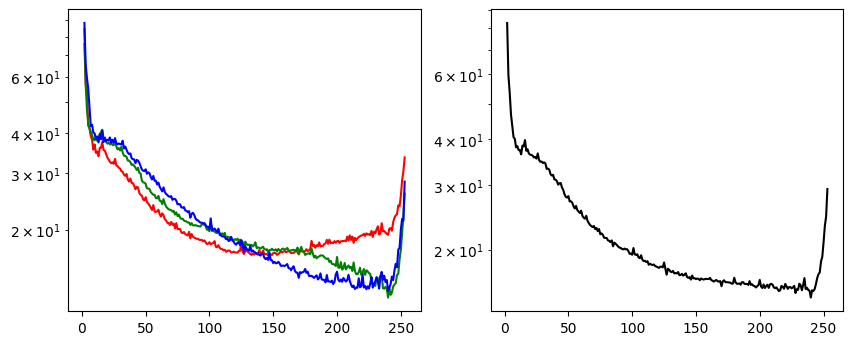

In [28]:
def trim_array(arr, left=2, right=2):
    out = np.copy(arr)
    out[:left] = np.nan
    out[-right:] = np.nan
    return out

def hist_from_series(col):
    return trim_array(np.stack(col.array).sum(axis=0))

def plot_hists(df, ax):
    ax.plot(hist_from_series(df.hist_reds), c='r')
    ax.plot(hist_from_series(df.hist_greens), c='g')
    ax.plot(hist_from_series(df.hist_blues), c='b')
    ax.set_yscale('log')

def plot_hists_mean(df, ax):
    ax.plot((hist_from_series(df.hist_reds) + hist_from_series(df.hist_greens) + hist_from_series(df.hist_blues))/3, c='k')
    ax.set_yscale('log')

fig, ax = plt.subplots(1, 2, figsize=(10, 4), dpi=100)
plot_hists(images_df, ax[0])
plot_hists_mean(images_df, ax[1])

#### Histogramy kolorów z podziałem na kategorie

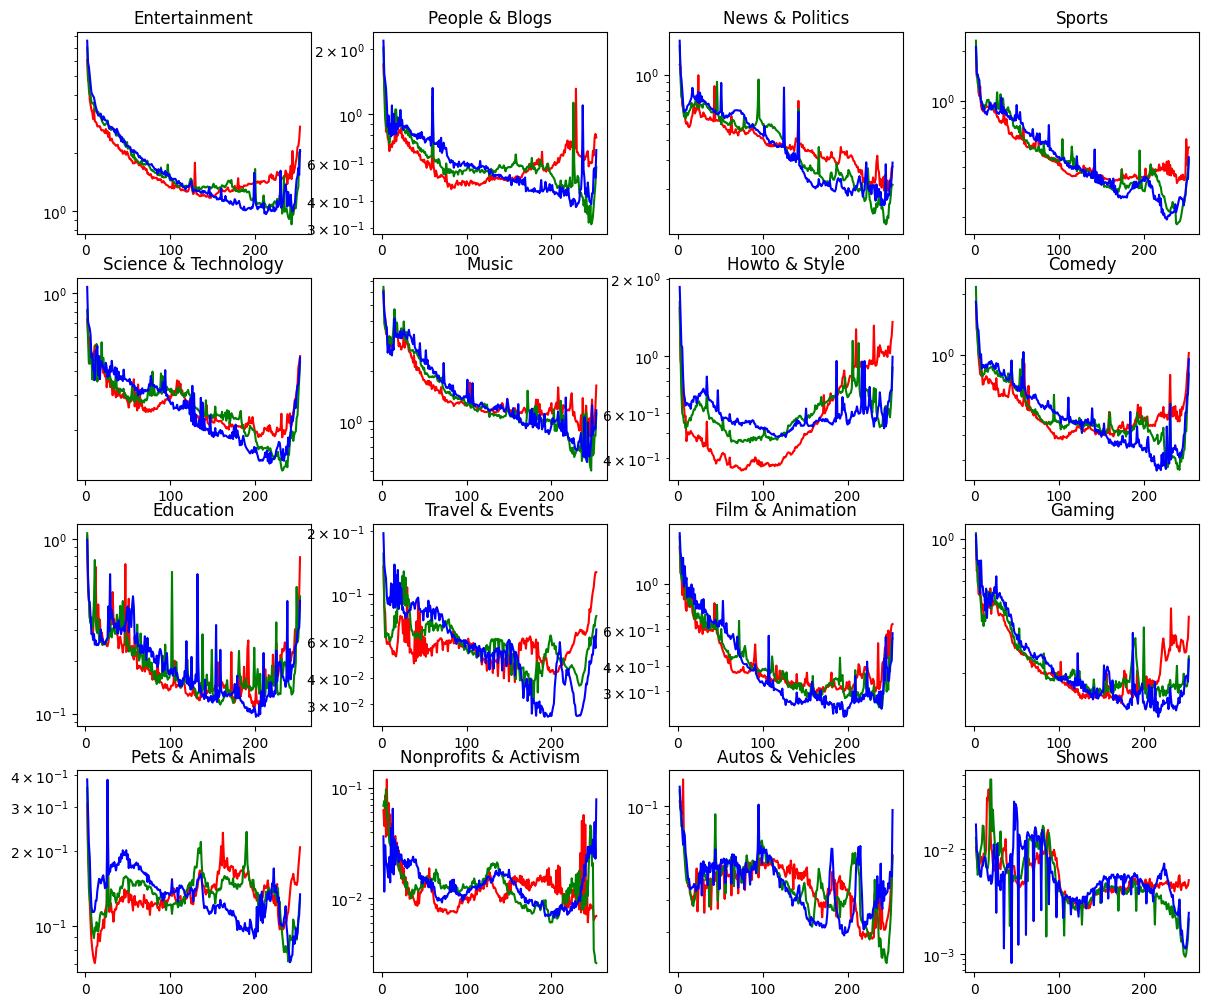

In [29]:
cats = [x for x in images_df.category_text.unique() if isinstance(x, str)]

fig, axs = plt.subplots(4,4, figsize=(12,10), dpi=100)
fig.tight_layout()

for (idx, ax), cat in zip(np.ndenumerate(axs), cats):
    ax.set(title=cat)
    plot_hists(images_df[images_df.category_text == cat], ax)

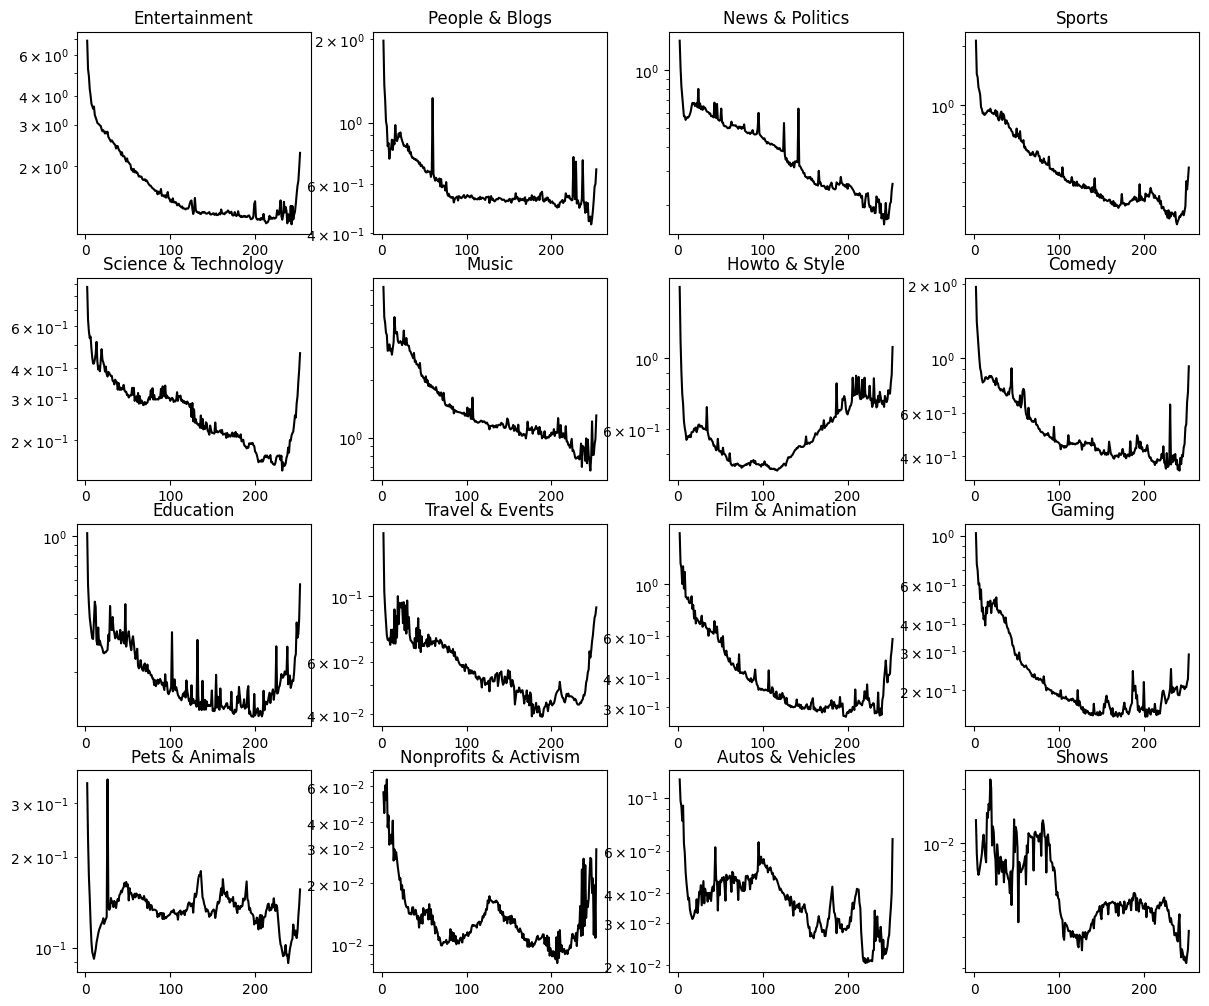

In [30]:
fig, axs = plt.subplots(4,4, figsize=(12,10), dpi=100)
fig.tight_layout()

for (idx, ax), cat in zip(np.ndenumerate(axs), cats):
    ax.set(title=cat)
    plot_hists_mean(images_df[images_df.category_text == cat], ax)

## Wektory Fishera

In [31]:
encoder = LabelEncoder()
lda = LinearDiscriminantAnalysis(solver='eigen', shrinkage='auto')
ys = encoder.fit_transform(images_df.category_text.dropna())

images_cat_df = images_df[images_df.category_text.notna()] 
Xs = (np.stack(images_cat_df.hist_reds) + np.stack(images_cat_df.hist_greens) + np.stack(images_cat_df.hist_blues)) / 3

print(Xs.shape, ys.shape)

(2597, 256) (2597,)


In [32]:
lda_path = cache_dir / 'lda.pkl'
if lda_path.exists():
    lda = load_pickle(lda_path)
else:
    lda.fit(Xs, ys)
    save_pickle(lda, lda_path)

encoded_hists = lda.transform(np.stack(images_df.hist_reds) + np.stack(images_df.hist_greens) + np.stack(images_df.hist_blues)) / 3
encoded_hists.shape

Loading from: data/cache/chkp2/lda.pkl


(7802, 15)

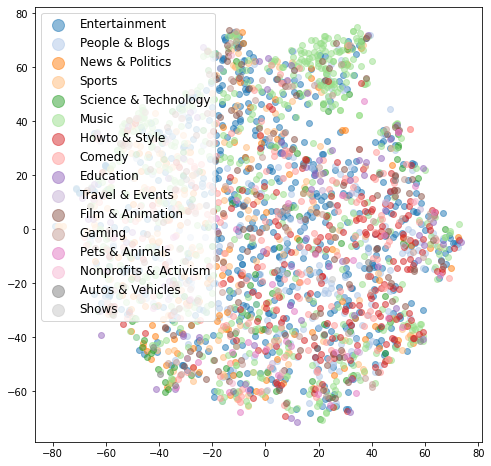

In [33]:
tsne_enc = TSNE().fit_transform(encoded_hists)

cmap = cm.get_cmap('tab20')
fig, ax = plt.subplots(figsize=(8,8))
tsne_cat = images_df['category_text'].values

for i, cat in enumerate(cats):
    idx = tsne_cat == cat
    ax.scatter(
        tsne_enc[idx, 0],
        tsne_enc[idx, 1],
        c = np.array(cmap(i)).reshape(1,4),
        label = cat,
        alpha = 0.5)
ax.legend(fontsize='large', markerscale=2)
plt.show()

## Wykrywanie twarzy

### Przykład

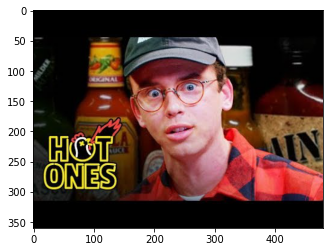

In [34]:
emotions_to_idx = {'Angry': 0, 'Sad': 5, 'Neutral': 4, 'Disgust': 1, 'Surprise': 6, 'Fear': 2, 'Happy': 3}
idx_to_emotions = {v:k for k,v in emotions_to_idx.items()}

img = face_recognition.load_image_file('data/images/__4c1JCHvaQ.jpg')
plt.imshow(img)

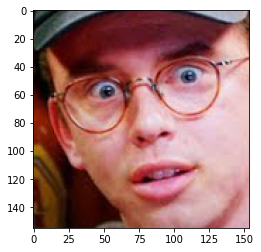

In [35]:
top, right, bottom, left = face_recognition.face_locations(img)[0]
face_image = img[top:bottom, left:right]
plt.imshow(face_image)

Shape (48, 48, 1)


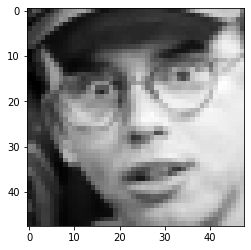

In [36]:
from tensorflow.keras.models import load_model

model = load_model('data/model_v6_23.hdf5')

face_image_2 = transform.resize(face_image, (48,48,3))
face_image_3 = color.rgb2gray(face_image_2)[..., np.newaxis]

print('Shape', face_image_3.shape)
plt.imshow(face_image_3, cmap='gray')

In [37]:
emotion_id = np.argmax(model.predict(face_image_3[np.newaxis,...]))
idx_to_emotions[emotion_id]

'Surprise'

### Implementacja

In [38]:
images_with_idx = list(zip(video_ids, images))

def process_face(img):
    face_img = transform.resize(img, (48,48,3))
    return color.rgb2gray(face_img)[..., np.newaxis]

def detect_faces(idx, img):
    faces = face_recognition.face_locations(img)
    return idx, [process_face(img[top:bottom, left:right]) for top, right, bottom, left in faces]

def detect_faces_tuple(pair):
    return detect_faces(pair[0], pair[1])

In [39]:
cpus = 16
size = len(images_with_idx)
chunksize = size // cpus

faces_path = cache_dir / 'faces.pkl'
if faces_path.exists():
    faces = load_pickle(faces_path)
else:
    with ProcessPool() as pool:
        future = pool.map(detect_faces_tuple, images_with_idx, chunksize=chunksize)
        iterator = future.result()
        faces = list(iterator)
        save_pickle(faces, faces_path)


images_df = images_df.join(pd.Series([len(f) for _, f in faces], index=[idx for idx, _ in faces], name='face_count'))
images_df.head()

Loading from: data/cache/chkp2/faces.pkl


category_text  \
--uXQQ0h-yQ   Entertainment   
-0CMnp02rNY             NaN   
-0NYY8cqdiQ             NaN   
-1Hm41N0dUs             NaN   
-1yT-K3c6YI  People & Blogs   

                                                        images  \
--uXQQ0h-yQ  [[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...   
-0CMnp02rNY  [[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...   
-0NYY8cqdiQ  [[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...   
-1Hm41N0dUs  [[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...   
-1yT-K3c6YI  [[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...   

                                                     hist_reds  \
--uXQQ0h-yQ  [0.23684027777777777, 0.0035185185185185185, 0...   
-0CMnp02rNY  [0.23108796296296297, 0.011134259259259259, 0....   
-0NYY8cqdiQ  [0.22815972222222222, 0.013142361111111112, 0....   
-1Hm41N0dUs  [0.22303819444444445, 0.011817129629629629, 0....   
-1yT-K3c6YI  [0.2153125, 0.013009259259259259, 0.0011631944...   

                                                   hist_greens  \
--uXQQ0h-yQ  [0.23438657407407407, 0.003616898148148148, 0....   
-0CMnp02rNY  [0.22734375, 0.011111111111111112, 0.007164351...   
-0NYY8cqdiQ  [0.22359953703703703, 0.012604166666666666, 0....   
-1Hm41N0dUs  [0.23289351851851853, 0.01342013888888889, 0.0...   
-1yT-K3c6YI  [0.23730324074074075, 0.008136574074074074, 0....   

                                                    hist_blues  face_count  
--uXQQ0h-yQ  [0.23497685185185185, 0.0027256944444444446, 0...           0  
-0CMnp02rNY  [0.2284548611111111, 0.005943287037037037, 0.0...           0  
-0NYY8cqdiQ  [0.22545138888888888, 0.006805555555555555, 0....           1  
-1Hm41N0dUs  [0.24511574074074075, 0.021782407407407407, 0....           1  
-1yT-K3c6YI  [0.22542824074074075, 0.004577546296296297, 0....           2

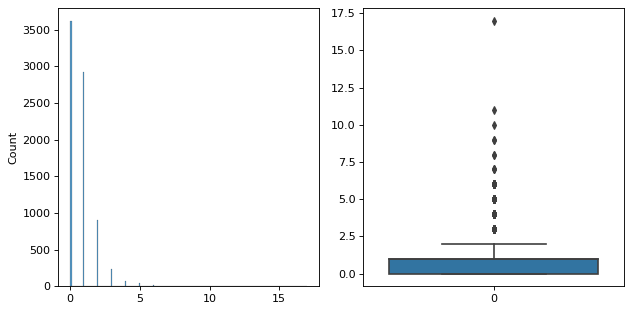

In [40]:
fig, ax = plt.subplots(1,2, figsize=(8,4), dpi=80) 
sns.histplot(data=[len(f) for _, f in faces], ax=ax[0])
sns.boxplot(data=[len(f) for _, f in faces], ax=ax[1])
fig.tight_layout()

#### Miniaturka o dużej liczbie twarzy (twarzowa)

VhexfxLPgTE


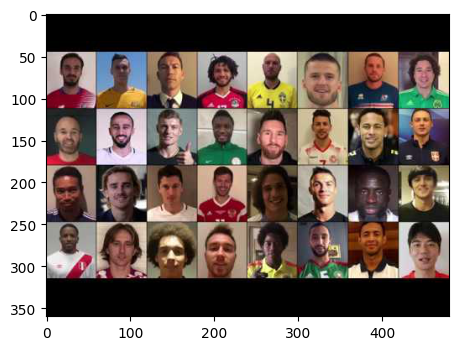

In [41]:
faceful_idx = Path([idx for idx, f in faces if len(f) > 15][0]).stem
print(faceful_idx)

fig, ax = plt.subplots(dpi=100)
plt.imshow(images_df.loc[faceful_idx,'images'])

## Detekcja emocji

In [42]:
from tensorflow.keras.models import load_model

model = load_model('data/model_v6_23.hdf5')

unrolled_faces = []
for idx, fs in faces:
    for f in fs:
        unrolled_faces.append((idx, f))

len(unrolled_faces)

6092

In [43]:
predicted_emotions = dict(idx=[], emotion=[])

BATCH_SIZE = 256

def chunks(lst, n):
    """Yield successive n-sized chunks from lst."""
    for i in range(0, len(lst), n):
        yield lst[i:i + n]


emotions_path = cache_dir / 'emotions.pkl'
if emotions_path.exists():
    predicted_emotions = load_pickle(emotions_path)
else:
    for batch in chunks(unrolled_faces, BATCH_SIZE):
        predictions = model.predict(np.array([b for _, b in batch]))
        predictions = [idx_to_emotions[x] for x in np.argmax(predictions, axis=1)]
        for (idx, _), emotion in zip(batch, predictions):
            predicted_emotions['idx'].append(idx)
            predicted_emotions['emotion'].append(emotion)

    save_pickle(predicted_emotions, emotions_path)

len(predicted_emotions['idx'])

Loading from: data/cache/chkp2/emotions.pkl


6092

### Rozkład emocji na twarzach

/home/hylomorph/Study/ped/yt_trending_videos/venv/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:ylabel='count'>

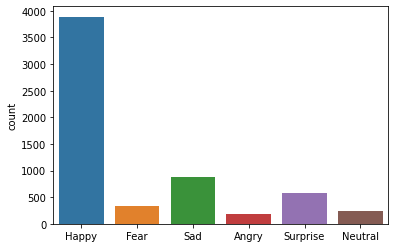

In [44]:
sns.countplot(predicted_emotions['emotion'])

In [45]:
emotions_df = {k: [] for k in images_df.index}
for k, e in zip(predicted_emotions['idx'], predicted_emotions['emotion']):
    emotions_df[Path(k).stem].append(e)

emotion_index = list([Path(k).stem for k in emotions_df.keys()])
emotions_df = pd.Series([emotions_df[i] for i in emotion_index], index=emotion_index, name='emotions')
images_df = images_df.join(emotions_df)
images_df.head()

category_text  \
--uXQQ0h-yQ   Entertainment   
-0CMnp02rNY             NaN   
-0NYY8cqdiQ             NaN   
-1Hm41N0dUs             NaN   
-1yT-K3c6YI  People & Blogs   

                                                        images  \
--uXQQ0h-yQ  [[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...   
-0CMnp02rNY  [[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...   
-0NYY8cqdiQ  [[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...   
-1Hm41N0dUs  [[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...   
-1yT-K3c6YI  [[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...   

                                                     hist_reds  \
--uXQQ0h-yQ  [0.23684027777777777, 0.0035185185185185185, 0...   
-0CMnp02rNY  [0.23108796296296297, 0.011134259259259259, 0....   
-0NYY8cqdiQ  [0.22815972222222222, 0.013142361111111112, 0....   
-1Hm41N0dUs  [0.22303819444444445, 0.011817129629629629, 0....   
-1yT-K3c6YI  [0.2153125, 0.013009259259259259, 0.0011631944...   

                                                   hist_greens  \
--uXQQ0h-yQ  [0.23438657407407407, 0.003616898148148148, 0....   
-0CMnp02rNY  [0.22734375, 0.011111111111111112, 0.007164351...   
-0NYY8cqdiQ  [0.22359953703703703, 0.012604166666666666, 0....   
-1Hm41N0dUs  [0.23289351851851853, 0.01342013888888889, 0.0...   
-1yT-K3c6YI  [0.23730324074074075, 0.008136574074074074, 0....   

                                                    hist_blues  face_count  \
--uXQQ0h-yQ  [0.23497685185185185, 0.0027256944444444446, 0...           0   
-0CMnp02rNY  [0.2284548611111111, 0.005943287037037037, 0.0...           0   
-0NYY8cqdiQ  [0.22545138888888888, 0.006805555555555555, 0....           1   
-1Hm41N0dUs  [0.24511574074074075, 0.021782407407407407, 0....           1   
-1yT-K3c6YI  [0.22542824074074075, 0.004577546296296297, 0....           2   

                  emotions  
--uXQQ0h-yQ             []  
-0CMnp02rNY             []  
-0NYY8cqdiQ        [Happy]  
-1Hm41N0dUs        [Happy]  
-1yT-K3c6YI  [Fear, Happy]

#### Embedding emocji

In [46]:
def embbed_emotions(x):
    c = Counter(x)
    return {'count_'+k.lower(): c.get(k, 0) for k in emotions_to_idx.keys()}

images_df = images_df.join(images_df.emotions.map(embbed_emotions).apply(pd.Series))
images_df.head()

category_text  \
--uXQQ0h-yQ   Entertainment   
-0CMnp02rNY             NaN   
-0NYY8cqdiQ             NaN   
-1Hm41N0dUs             NaN   
-1yT-K3c6YI  People & Blogs   

                                                        images  \
--uXQQ0h-yQ  [[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...   
-0CMnp02rNY  [[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...   
-0NYY8cqdiQ  [[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...   
-1Hm41N0dUs  [[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...   
-1yT-K3c6YI  [[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...   

                                                     hist_reds  \
--uXQQ0h-yQ  [0.23684027777777777, 0.0035185185185185185, 0...   
-0CMnp02rNY  [0.23108796296296297, 0.011134259259259259, 0....   
-0NYY8cqdiQ  [0.22815972222222222, 0.013142361111111112, 0....   
-1Hm41N0dUs  [0.22303819444444445, 0.011817129629629629, 0....   
-1yT-K3c6YI  [0.2153125, 0.013009259259259259, 0.0011631944...   

                                                   hist_greens  \
--uXQQ0h-yQ  [0.23438657407407407, 0.003616898148148148, 0....   
-0CMnp02rNY  [0.22734375, 0.011111111111111112, 0.007164351...   
-0NYY8cqdiQ  [0.22359953703703703, 0.012604166666666666, 0....   
-1Hm41N0dUs  [0.23289351851851853, 0.01342013888888889, 0.0...   
-1yT-K3c6YI  [0.23730324074074075, 0.008136574074074074, 0....   

                                                    hist_blues  face_count  \
--uXQQ0h-yQ  [0.23497685185185185, 0.0027256944444444446, 0...           0   
-0CMnp02rNY  [0.2284548611111111, 0.005943287037037037, 0.0...           0   
-0NYY8cqdiQ  [0.22545138888888888, 0.006805555555555555, 0....           1   
-1Hm41N0dUs  [0.24511574074074075, 0.021782407407407407, 0....           1   
-1yT-K3c6YI  [0.22542824074074075, 0.004577546296296297, 0....           2   

                  emotions  count_angry  count_sad  count_neutral  \
--uXQQ0h-yQ             []            0          0              0   
-0CMnp02rNY             []            0          0              0   
-0NYY8cqdiQ        [Happy]            0          0              0   
-1Hm41N0dUs        [Happy]            0          0              0   
-1yT-K3c6YI  [Fear, Happy]            0          0              0   

             count_disgust  count_surprise  count_fear  count_happy  
--uXQQ0h-yQ              0               0           0            0  
-0CMnp02rNY              0               0           0            0  
-0NYY8cqdiQ              0               0           0            1  
-1Hm41N0dUs              0               0           0            1  
-1yT-K3c6YI              0               0           1            1

## Wykrywanie tekstu

### Pobieranie modelu

In [47]:
# !wget https://raw.githubusercontent.com/oyyd/frozen_east_text_detection.pb/master/frozen_east_text_detection.pb
# !mv frozen_east_text_detection.pb  data/.

In [48]:


east_model = cv.dnn.readNet('data/frozen_east_text_detection.pb')
east_model

<dnn_Net 0x7f939456caf0>

(360, 480, 3)
(360, 480, 3)


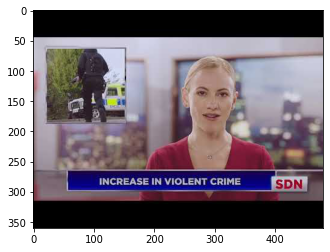

In [49]:
img = images[1213].copy()
print(img.shape)

(H, W) = img.shape[:2]
# set the new width and height and then determine the ratio in change
# for both the width and height
newW, newH = 320, 320
rW = W / float(newW)
rH = H / float(newH)
# resize the image and grab the new image dimensions
(H, W) = img.shape[:2]
print(img.shape)

plt.imshow(img)

In [50]:
blob = cv.dnn.blobFromImage(img, 1.0, (320, 320), (123.68, 116.78, 103.94), False, False)
print(img.shape)
# img = transform.resize(img, (newW, newH))

(360, 480, 3)


#### Multi-blobs demo

In [51]:
imgs = images[1210:1250].copy()
blobs = cv.dnn.blobFromImages(imgs, 1.0, (320, 320), (123.68, 116.78, 103.94), False, False)
blobs.shape

(40, 3, 320, 320)

In [52]:
outputLayers = []
outputLayers.append("feature_fusion/Conv_7/Sigmoid")
outputLayers.append("feature_fusion/concat_3")

In [53]:
east_model.setInput(blob)
output = east_model.forward(outputLayers)

scores, geometry = output
scores.shape, geometry.shape

((1, 1, 80, 80), (1, 5, 80, 80))

#### Multiblob net

In [54]:
east_model.setInput(blobs)
outputs = east_model.forward(outputLayers)
len(outputs)

2

In [55]:
outputs[0].shape, outputs[1].shape

((40, 1, 80, 80), (40, 5, 80, 80))

In [56]:
def decode(scores, geometry, min_confidence):
    '''https://www.pyimagesearch.com/2018/08/20/opencv-text-detection-east-text-detector/'''
    (numRows, numCols) = scores.shape[2:4]
    rects = []
    confidences = []
    # loop over the number of rows
    for y in range(0, numRows):
        # extract the scores (probabilities), followed by the geometrical
        # data used to derive potential bounding box coordinates that
        # surround text
        scoresData = scores[0, 0, y]
        xData0 = geometry[0, 0, y]
        xData1 = geometry[0, 1, y]
        xData2 = geometry[0, 2, y]
        xData3 = geometry[0, 3, y]
        anglesData = geometry[0, 4, y]

        # loop over the number of columns
        for x in range(0, numCols):
            # if our score does not have sufficient probability, ignore it
            if scoresData[x] < min_confidence:
                continue
            # compute the offset factor as our resulting feature maps will
            # be 4x smaller than the input image
            (offsetX, offsetY) = (x * 4.0, y * 4.0)
            # extract the rotation angle for the prediction and then
            # compute the sin and cosine
            angle = anglesData[x]
            cos = np.cos(angle)
            sin = np.sin(angle)
            # use the geometry volume to derive the width and height of
            # the bounding box
            h = xData0[x] + xData2[x]
            w = xData1[x] + xData3[x]
            # compute both the starting and ending (x, y)-coordinates for
            # the text prediction bounding box
            endX = int(offsetX + (cos * xData1[x]) + (sin * xData2[x]))
            endY = int(offsetY - (sin * xData1[x]) + (cos * xData2[x]))
            startX = int(endX - w)
            startY = int(endY - h)
            # add the bounding box coordinates and probability score to
            # our respective lists
            rects.append((startX, startY, endX, endY))
            confidences.append(scoresData[x])

    return rects, confidences

In [57]:

[boxes, confidences] = decode(scores, geometry, 0.3)
boxes = non_max_suppression(np.array(boxes), confidences)

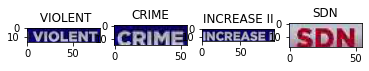

In [58]:


fig, ax = plt.subplots(1, len(boxes))

for idx, (startX, startY, endX, endY) in enumerate(boxes):
    startX = int(startX*rW)
    startY = int(startY*rH)
    endX = int(endX*rW)
    endY = int(endY*rH)
    
    label = pytesseract.image_to_string(img[startY:endY, startX:endX, :], config="--oem 3 --psm 6")
    labels = [re.sub(r'\W+', '', l) for l in  label.split(r' ')]
    label = ' '.join(labels)
    ax[idx].set_title(label)
    ax[idx].imshow(img[startY:endY, startX:endX, :])


### Implementacja
#### Propozycje regionów

In [59]:
east_regions_path = cache_dir / 'east_regions.pkl'

if east_regions_path.exists():
    east_regions = load_pickle(east_regions_path)
else:
    east_regions = {'idx': [], 'scores': [], 'geometry': []}
    for batch in tqdm(chunks(images_with_idx, BATCH_SIZE)):
        imgs = [b[1].copy() for b in batch]
        blobs = cv.dnn.blobFromImages(imgs, 1.0, (320, 320), (123.68, 116.78, 103.94), False, False)
        east_model.setInput(blobs)
        outputs = east_model.forward(outputLayers)
        east_regions['idx'] += [b[0] for b in batch]
        east_regions['scores'].append(outputs[0])
        east_regions['geometry'].append(outputs[1])

    save_pickle(east_regions, east_regions_path)

east_regions.keys()
east_regions['scores'] = np.vstack(east_regions['scores'])
east_regions['geometry'] = np.vstack(east_regions['geometry']) 

len(east_regions['idx']), east_regions['scores'].shape, east_regions['geometry'].shape

Loading from: data/cache/chkp2/east_regions.pkl


(7802, (7802, 1, 80, 80), (7802, 5, 80, 80))

In [60]:
def detect_words(vals):
    idx, boxes = vals

    text = []
    for startX, startY, endX, endY in boxes:
        startX = int(startX*rW)
        startY = int(startY*rH)
        endX = int(endX*rW)
        endY = int(endY*rH)
        
        try:
            label = pytesseract.image_to_string(img[startY:endY, startX:endX, :], config="--oem 3 --psm 6")
            labels = [re.sub(r'\W+', '', l) for l in  label.split(r' ')]
            text += [l for l in labels if len(l) > 2]
        except:
            pass
    
    return idx, text


def detect_boxes(vals):
    idx, scores, geometry = vals

    [boxes, confidences] = decode(scores[np.newaxis,...], geometry[np.newaxis,...], 0.3)
    boxes = non_max_suppression(np.array(boxes), confidences)

    return idx, boxes

#### Demo

In [61]:
for i, t in enumerate(zip(east_regions['idx'], east_regions['scores'], east_regions['geometry'])):
    print(detect_boxes(t))
    if i > 10:
        break

('--uXQQ0h-yQ', [])
('-0CMnp02rNY', [])
('-0NYY8cqdiQ', [])
('-1Hm41N0dUs', array([[ 33, 195,  99, 232],
       [127, 132, 159, 148],
       [ 69, 233, 113, 256],
       [167, 139, 203, 151],
       [114, 152, 137, 188],
       [147, 120, 194, 132],
       [ -6, 199,  19, 219],
       [246, 165, 318, 177]]))
('-1yT-K3c6YI', array([[111, 236, 194, 268],
       [106, 161, 191, 198],
       [116, 199, 176, 232]]))
('-2RVw2_QyxQ', array([[165, 220, 294, 244],
       [168, 193, 289, 219],
       [ 99, 205, 120, 218],
       [ 79, 201, 102, 215]]))
('-2aVkGcI7ZA', array([[221,  63, 263,  87],
       [ 48,  51, 109,  66]]))
('-2b4qSoMnKE', array([[ 13, 200, 122, 268]]))
('-2wRFv-mScQ', array([[110, 178, 159, 226],
       [ 16, 182, 105, 225],
       [146, 184, 244, 225],
       [ 20, 101,  98, 171]]))
('-35jibKqbEo', array([[210, 139, 236, 149],
       [134, 139, 162, 151],
       [159, 140, 187, 151],
       [232, 138, 258, 149],
       [184, 140, 208, 150]]))
('-37nIo_tLnk', array([[ 82, 23

### Predykcja tekstu

In [62]:
cpus = 16
size = len(images_with_idx)
chunksize = size // cpus

detected_boxes_path = cache_dir / 'detected_boxes.pkl'
if detected_boxes_path.exists():
    detected_boxes = load_pickle(detected_boxes_path)
else:
    with ProcessPool() as pool:
        values = zip(east_regions['idx'], east_regions['scores'], east_regions['geometry'])

        future = pool.map(detect_boxes, values, chunksize=chunksize)
        iterator = future.result()
        detected_boxes = list(iterator)
        save_pickle(detected_boxes, detected_boxes_path)

Loading from: data/cache/chkp2/detected_boxes.pkl


In [63]:
for i, b in enumerate(detected_boxes):
    print(detect_words(b))
    if i > 10:
        break

('--uXQQ0h-yQ', [])
('-0CMnp02rNY', [])
('-0NYY8cqdiQ', [])
('-1Hm41N0dUs', ['INCREA'])
('-1yT-K3c6YI', ['SETAC'])
('-2RVw2_QyxQ', ['SSS'])
('-2aVkGcI7ZA', [])
('-2b4qSoMnKE', [])
('-2wRFv-mScQ', ['hehe', 'aitich'])
('-35jibKqbEo', [])
('-37nIo_tLnk', [])
('-39ysKKpE7I', ['PReay'])


In [64]:
detected_words_path = cache_dir / 'detected_words.pkl'
if detected_words_path.exists():
    detected_words = load_pickle(detected_words_path)
else:
    detected_words = [detect_words(b) for b in tqdm(detected_boxes)]
    save_pickle(detected_words, detected_words_path)

Loading from: data/cache/chkp2/detected_words.pkl


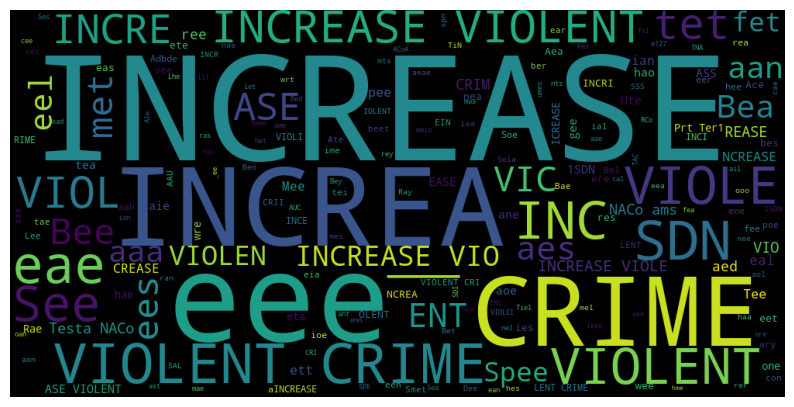

In [68]:
wc = WordCloud(width=1000, height=500).generate(" ".join([' '.join(w) for _, w in detected_words if w]))

plt.figure(figsize=(10,6), dpi=100)
plt.axis("off")
plt.imshow(wc)

## Proste cechy
### HOG - Histogram of Oriented Gradients

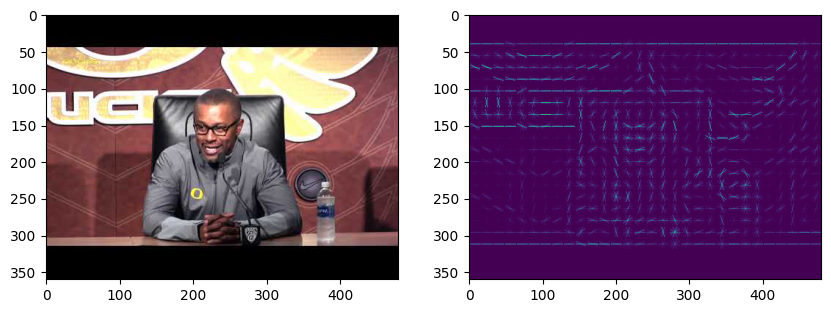

In [92]:
img = images[42]
desc, viz = skfeature.hog(img, pixels_per_cell=(16, 16), visualize=True, multichannel=True)

fig, ax = plt.subplots(1, 2, figsize=(10,6), dpi=100)
ax[0].imshow(img)
ax[1].imshow(viz)

Daisy is very slow

In [95]:
# img = images[42]
# desc, viz = skfeature.daisy(color.rgb2gray(img), visualize=True)

# fig, ax = plt.subplots(1, 2, figsize=(10,6), dpi=100)
# ax[0].imshow(img)
# ax[1].imshow(viz)

### Średnie i mediany kolorów

In [118]:
def simple_description(image):
    color_vectors = image.reshape(-1, 3).T
    output = {}
    for c, n in zip(color_vectors, ['red', 'green', 'blue']):
        output['mean_'+n] = np.mean(c)
        output['median_'+n] = np.median(c)
        output['iqr_'+n] = iqr(c)
        
    return output

simple_df_path = cache_dir / 'simple_df.pkl'
if simple_df_path.exists():
    simple_df = load_pickle(simple_df_path)
else:
    simple_df = images_df.images.map(simple_description).apply(pd.Series)
    simple_df.index = images_df.index
    save_pickle(simple_df, simple_df_path)

simple_df.head()

Loading from: data/cache/chkp2/simple_df.pkl


mean_red  median_red  iqr_red  mean_green  median_green  \
--uXQQ0h-yQ   68.470885        24.0    189.0   70.466418          24.0   
-0CMnp02rNY   90.574479        69.0    172.0   93.971152          95.0   
-0NYY8cqdiQ   97.887002        69.0    198.0  102.937506         108.0   
-1Hm41N0dUs   87.541626        61.0    175.0   71.689728          38.0   
-1yT-K3c6YI  123.836574       111.0    221.0   99.759410          90.0   

             iqr_green   mean_blue  median_blue  iqr_blue  
--uXQQ0h-yQ      197.0   69.670150         26.0     193.0  
-0CMnp02rNY      162.0  100.170700        107.0     178.0  
-0NYY8cqdiQ      186.0  109.637251        124.0     190.0  
-1Hm41N0dUs      133.0   67.879913         28.0     126.0  
-1yT-K3c6YI      174.0  101.422269         89.0     172.0

In [119]:
images_df = images_df.join(simple_df)

In [122]:
fig = px.scatter_3d(images_df[images_df.category_text.notna()], x='mean_red', y='mean_green', z='mean_blue', color='category_text')
fig.show()